In [1]:
#from preprocess import Preprocess

import json
import pandas as pd

import re 
from datetime import datetime

import matplotlib.pyplot as plt

In [2]:
class Preprocessor:
    def __init__(self, data):
        self.data = data
    
    def preprocess(self):
        input_keys = list(self.data['results']['root_node']['results'].keys())
        for i in input_keys:
            for j in self.data['results']['root_node']['results'][i]['results']:
                yield {
                    'created_at': j['created_at'],
                    'project_node_input_id': j['project_node_input_id'],
                    'project_node_output_id': j['project_node_output_id'],
                    'workpackage_total_size': j['workpackage_total_size'],
                    'loss': j['loss'],

                    # task_output
                    'answer': j['task_output']['answer'], 
                    'cant_solve': j['task_output']['cant_solve'],
                    'corrupt_data': j['task_output']['corrupt_data'],
                    'duration_ms': j['task_output']['duration_ms'],

                    # user
                    'vendor_id': j['user']['vendor_id'],
                    'vendor_user_id': j['user']['vendor_user_id'],
                    'id': j['user']['id'],
                    'image_url': j['task_input']['image_url'],
                }


In [3]:
if __name__ == '__main__':
    with open('./data/anonymized_project.json', 'r') as f:
        data = json.load(f)

In [4]:
# loading the dataframe by instantiating the Preprocessor class

d = Preprocessor(data)
df = pd.DataFrame(d.preprocess())

In [5]:
df.head()

,created_at,project_node_input_id,project_node_output_id,workpackage_total_size,loss,answer,cant_solve,corrupt_data,duration_ms,vendor_id,vendor_user_id,id,image_url
0,2021-02-25T14:08:11.319438+00:00,7e8984b6-dff7-4015-865a-b721a2faf681,0000439a-96ac-4bd4-8753-a4baa229ecf2,5,0.0,no,False,False,997,vendor_01,annotator_12,08af8775-a72c-4c59-b60f-9ce7df04fa92,https://qm-auto-annotator.s3.eu-central-1.amaz...
1,2021-02-25T13:14:39.411149+00:00,7e8984b6-dff7-4015-865a-b721a2faf681,0488b469-7c5f-459a-bfcb-ed94957c09c2,5,0.0,no,False,False,845,vendor_01,annotator_11,62f1cf90-71c9-45c5-990c-f9dc0aa6ea3d,https://qm-auto-annotator.s3.eu-central-1.amaz...
2,2021-02-25T15:19:57.889434+00:00,7e8984b6-dff7-4015-865a-b721a2faf681,323902a9-3b41-4885-8796-4e393aa2e0a0,5,0.0,no,False,False,1468,vendor_01,annotator_22,780c974e-6ce7-4f1d-9afe-56bf96753fca,https://qm-auto-annotator.s3.eu-central-1.amaz...
3,2021-02-26T03:56:18.770331+00:00,7e8984b6-dff7-4015-865a-b721a2faf681,4222ac20-7aaa-4b07-bb2b-4423bf41eefe,5,0.0,no,False,False,1062,vendor_01,annotator_17,94afdf79-917c-4904-bdaa-7a121f33b0ff,https://qm-auto-annotator.s3.eu-central-1.amaz...
4,2021-02-25T15:39:06.644705+00:00,7e8984b6-dff7-4015-865a-b721a2faf681,42ba767f-5bd1-4e62-aff1-4e716fd23623,5,0.0,no,False,False,879,vendor_01,annotator_02,37a6036c-a9ef-4fcb-b554-7058f00415db,https://qm-auto-annotator.s3.eu-central-1.amaz...


In [18]:
# changing the type of some columns, creating new ones for further analysis

df['created_at'] = pd.to_datetime(df['created_at'])
df.set_index('created_at', inplace=True)

df['image_name'] = df['image_url'].str.extract('\/(\w+)\.jpg$').fillna('')

# dropping the columns where all values are the same - optional

#cols_to_drop = [col for col in df.columns if df[col].nunique() == 1]
#df.drop(cols_to_drop, axis=1, inplace=True)

In [6]:
# loading the ref dataset

with open('./data/references.json', 'r') as f:
    ref = json.load(f)

In [7]:
references = pd.DataFrame([(k, v['is_bicycle']) for k, v in ref.items()], columns=['image_name', 'is_bicycle'])
references.head()

,image_name,is_bicycle
0,img_4686,False
1,img_8607,True
2,img_5541,False
3,img_3218,False
4,img_3247,True


## Analysis

In [8]:
# a. How many annotators did contribute to the dataset?

print("{} annotators contributed to the dataset".format(df.vendor_user_id.nunique()))

22 annotators contributed to the dataset


In [9]:
#b. What are the average, min and max annotation times (durations)? Feel free to
# add visual representations here such as graphs if you like.

<AxesSubplot:>

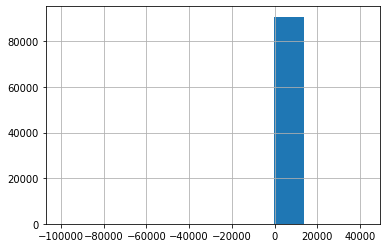

In [10]:
df.duration_ms.hist()

In [11]:
# negative duration does not make a lot of sense

df = df[df.duration_ms > 0]

In [12]:
print("Maximum duration: {:.1f} ms\nMinimum duration: {:.1f} ms\nAverage duration: {:.1f} ms".format(df.duration_ms.max(), df.duration_ms.min(), df.duration_ms.mean()))


Maximum duration: 42398.0 ms
Minimum duration: 10.0 ms
Average duration: 1289.9 ms


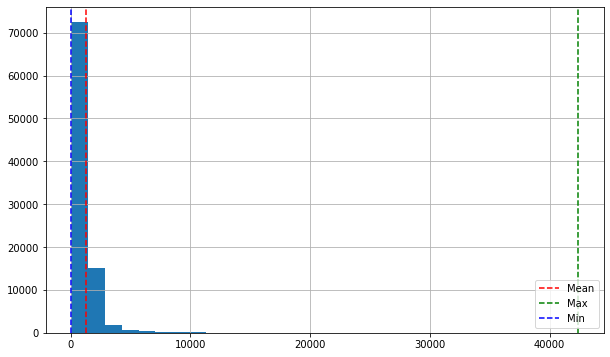

In [13]:
plt.figure(figsize=(10,6))
ax=df.duration_ms.hist(bins=30)
plt.axvline(df.duration_ms.mean(), color='r', linestyle='--', label='Mean')
plt.axvline(df.duration_ms.max(), color='g', linestyle='--', label='Max')
plt.axvline(df.duration_ms.min(), color='b', linestyle='--', label='Min')
plt.legend(loc='lower right')
plt.show()

In [14]:
# c. Did all annotators produce the same amount of results, or are there differences?

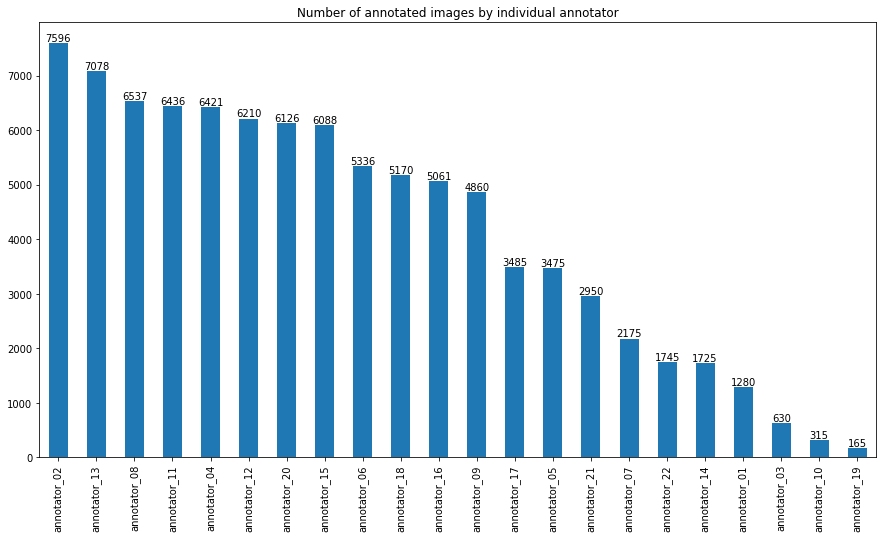

In [15]:
plt.figure(figsize=(15, 8))

counts = df.vendor_user_id.value_counts()
ax = counts.plot(kind='bar')

for i, count in enumerate(counts):
    ax.text(i, count+0.1, str(count), ha='center', va='bottom')
plt.title("Number of annotated images by individual annotator")

plt.show()


In [22]:
# d. Are there questions for which annotators highly disagree?

answ = pd.pivot_table(df, index='image_name', columns='answer', values='vendor_user_id', aggfunc='count').fillna(0)
answ = answ.reset_index()

In [24]:
# calculating the percentage of each answer

answ['yes_pct'] = answ.apply(lambda row: (row['yes'] / (row['yes'] + row['no'])) * 100, axis=1)
answ['no_pct'] = answ.apply(lambda row: (row['no'] / (row['yes'] + row['no'])) * 100, axis=1)

In [25]:
answ['agreement'] = abs(answ.yes_pct - answ.no_pct)
# absolute value difference bewteen the number of responses, the lower the value, the higher the disagreement

In [26]:
answ = answ.sort_values(by='agreement')
answ[answ.agreement == 0]

answer,image_name,,no,yes,yes_pct,no_pct,agreement
7533,img_7533,0.0,5.0,5.0,50.0,50.0,0.0
7309,img_7309,0.0,5.0,5.0,50.0,50.0,0.0
3771,img_3771,0.0,5.0,5.0,50.0,50.0,0.0
3382,img_3382,0.0,5.0,5.0,50.0,50.0,0.0
7080,img_7080,0.0,5.0,5.0,50.0,50.0,0.0
...,...,...,...,...,...,...,...
2414,img_2414,0.0,5.0,5.0,50.0,50.0,0.0
5299,img_5299,0.0,5.0,5.0,50.0,50.0,0.0
7455,img_7455,0.0,5.0,5.0,50.0,50.0,0.0
4782,img_4782,0.0,5.0,5.0,50.0,50.0,0.0


In [27]:
print("The users have polar opinions on {} pictures".format(len(answ[answ.agreement == 0])))

The users have polar opinions on 68 pictures


In [28]:
print("Marked as corrupt: {} responses, {:.3f}% from total responses\nCouldn't solve: {} responses, {:.3f}% from total responses\n".format(len(df[df.corrupt_data == True]), 
                                                                                                                                          len(df[df.corrupt_data == True]) / len(df) * 100, 
                                                                                                                                          len(df[df.cant_solve == True]), 
                                                                                                                                          len(df[df.cant_solve == True]) / len(df) * 100))


Marked as corrupt: 3 responses, 0.003% from total responses
Couldn't solve: 17 responses, 0.019% from total responses



In [29]:
# by individual annotators

print('Cant solve:\n', df[(df.cant_solve == True)].groupby('vendor_user_id').size())
print('Marked data as corrupt:\n',df[(df.corrupt_data == True)].groupby('vendor_user_id').size())

Cant solve:
 vendor_user_id
annotator_02    2
annotator_04    4
annotator_07    1
annotator_08    2
annotator_11    1
annotator_14    1
annotator_18    1
annotator_20    1
annotator_22    4
dtype: int64
Marked data as corrupt:
 vendor_user_id
annotator_08    1
annotator_18    2
dtype: int64


In [30]:
# by anotators: both marked as corrupt and couldn't solve

df[(df.cant_solve == True) | (df.corrupt_data == True)].groupby('vendor_user_id').size().sort_values(ascending=False)

vendor_user_id
annotator_04    4
annotator_22    4
annotator_08    3
annotator_18    3
annotator_02    2
annotator_07    1
annotator_11    1
annotator_14    1
annotator_20    1
dtype: int64

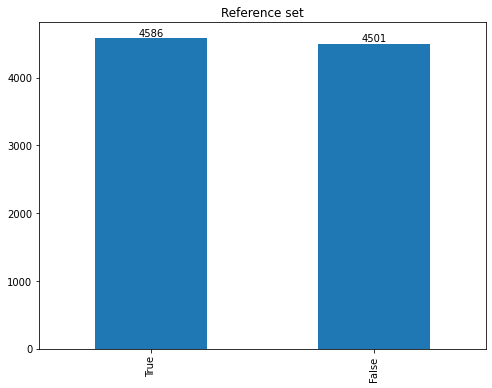

In [31]:
plt.figure(figsize=(8, 6))

counts = references['is_bicycle'].value_counts()
ax = counts.plot(kind='bar')

for i, count in enumerate(counts):
    ax.text(i, count+0.1, str(count), ha='center', va='bottom')

plt.title("Reference set")
plt.show()

# seems to be quite balanced

In [32]:
df.groupby('answer').size() # as well as the answers

answer
          20
no     44715
yes    46129
dtype: int64

In [33]:
df = pd.merge(df, references, on='image_name')

In [34]:
df.answer = df.answer.replace({'yes': True, 'no': False}).astype(bool)

In [35]:
# Total metrics: with sklearn
from sklearn import metrics

accuracy = metrics.accuracy_score(df.is_bicycle, df.answer)
precision = metrics.precision_score(df.is_bicycle, df.answer)
recall = metrics.recall_score(df.is_bicycle, df.answer)

print("Total accuracy: {:.3f} \nTotal precision: {:.3f} \nTotal recall: {:.3f}".format(accuracy, precision, recall)) 

Total accuracy: 0.935 
Total precision: 0.933 
Total recall: 0.938


In [36]:
# or if we want to do it by hand:

tp = sum(df["is_bicycle"] & df["answer"])
fp = sum((df["is_bicycle"] == 0) & (df["answer"] == 1))
tn = sum((df["is_bicycle"] == 0) & (df["answer"] == 0))
fn = sum(df["is_bicycle"] & (df["answer"] == 0))
precision_ = tp / (tp + fp)
recall_ = tp / (tp + fn)
accuracy_ = (tp + tn) / len(df)

In [37]:
print("Total accuracy: {:.3f} \nTotal precision: {:.3f} \nTotal recall: {:.3f}".format(accuracy_, precision_, recall_)) 

Total accuracy: 0.935 
Total precision: 0.933 
Total recall: 0.938


In [38]:
# another metric: Cohen's kappa
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(df.is_bicycle, df.answer)
print("Cohen's kappa:", kappa)

# kappa is smaller than total accuracy, but that is normal - TBD on the presentation

Cohen's kappa: 0.8695226110483331


In [34]:
# by individual annotators

In [39]:
annotators_ranked = df[df['answer'] == df['is_bicycle']].groupby('vendor_user_id').size().reset_index().sort_values(by=0,ascending=False)
annotators_ranked.rename(columns={0: 'correct'}, inplace=True)

In [40]:
total_counts = df['vendor_user_id'].value_counts().to_frame().reset_index().rename(columns={'index': 'vendor_user_id', 'vendor_user_id': 'total_count'})
annotators_ranked = pd.merge(annotators_ranked, total_counts, on='vendor_user_id')

In [41]:
results = []
for user_id, group in df.groupby("vendor_user_id"):
    tp = sum(group["is_bicycle"] & group["answer"])
    fp = sum((group["is_bicycle"] == 0) & (group["answer"] == 1))
    tn = sum((group["is_bicycle"] == 0) & (group["answer"] == 0))
    fn = sum(group["is_bicycle"] & (group["answer"] == 0))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / len(group)
    results.append({"vendor_user_id": user_id, "precision": precision, "recall": recall, "accuracy": accuracy})

acc_results = pd.DataFrame(results)

In [42]:
annotators_ranked = pd.merge(annotators_ranked, acc_results, on='vendor_user_id')

In [43]:
annotators_ranked = annotators_ranked.sort_values(by="accuracy", ascending=False)

best_annotator = annotators_ranked.iloc[0]["vendor_user_id"]
worst_annotator = annotators_ranked.iloc[-1]["vendor_user_id"]

In [41]:
# best / worst annotator

print("The user with the total highest accuracy is {} with accuracy {:.3f}".format(best_annotator, annotators_ranked.iloc[0]["accuracy"]))
print("The user with the total lowest accuracy is {} with accuracy {:.3f}".format(worst_annotator, annotators_ranked.iloc[-1]["accuracy"]))

The user with the total highest accuracy is annotator_01 with accuracy 0.948
The user with the total lowest accuracy is annotator_10 with accuracy 0.889


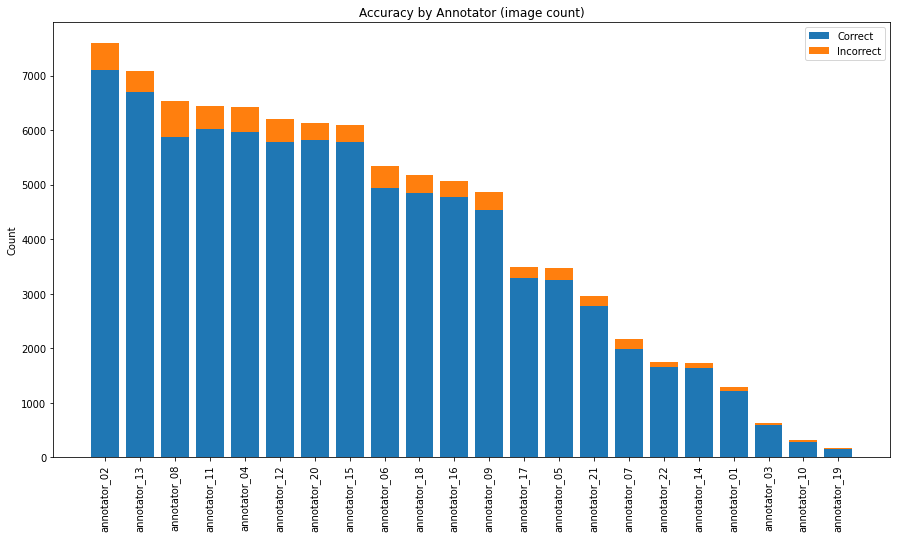

In [45]:
annotators_ranked = annotators_ranked.sort_values(by="total_count", ascending=False)

plt.figure(figsize=(15, 8))

plt.bar(annotators_ranked['vendor_user_id'], annotators_ranked['correct'], label='Correct')
plt.bar(annotators_ranked['vendor_user_id'], annotators_ranked['total_count'] - annotators_ranked['correct'], bottom=annotators_ranked['correct'], label='Incorrect')
plt.legend()
plt.title('Accuracy by Annotator (image count)')
#plt.xlabel('Annotator')
plt.ylabel('Count')
plt.xticks(rotation=90)

plt.show()

In [46]:
# optional: ROC AUC curve (but maybe more of help, when the dataset is imbalanced)

from sklearn.metrics import roc_auc_score

roc_auc_scores = []

for user_id, user_df in df.groupby("vendor_user_id"):
    roc_auc = roc_auc_score(user_df["is_bicycle"], user_df["answer"])
    roc_auc_scores.append((user_id, roc_auc))

roc_auc_df = pd.DataFrame(roc_auc_scores, columns=["user_id", "roc_auc"])
print(roc_auc_df)

         user_id   roc_auc
0   annotator_01  0.948090
1   annotator_02  0.934822
2   annotator_03  0.928475
3   annotator_04  0.928012
4   annotator_05  0.937033
5   annotator_06  0.926015
6   annotator_07  0.915176
7   annotator_08  0.899162
8   annotator_09  0.933397
9   annotator_10  0.883679
10  annotator_11  0.936510
11  annotator_12  0.928898
12  annotator_13  0.946858
13  annotator_14  0.946669
14  annotator_15  0.948392
15  annotator_16  0.942560
16  annotator_17  0.942435
17  annotator_18  0.936716
18  annotator_19  0.945221
19  annotator_20  0.948259
20  annotator_21  0.939954
21  annotator_22  0.943270


In [47]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(df["is_bicycle"], df["answer"])
roc_auc = auc(fpr, tpr)

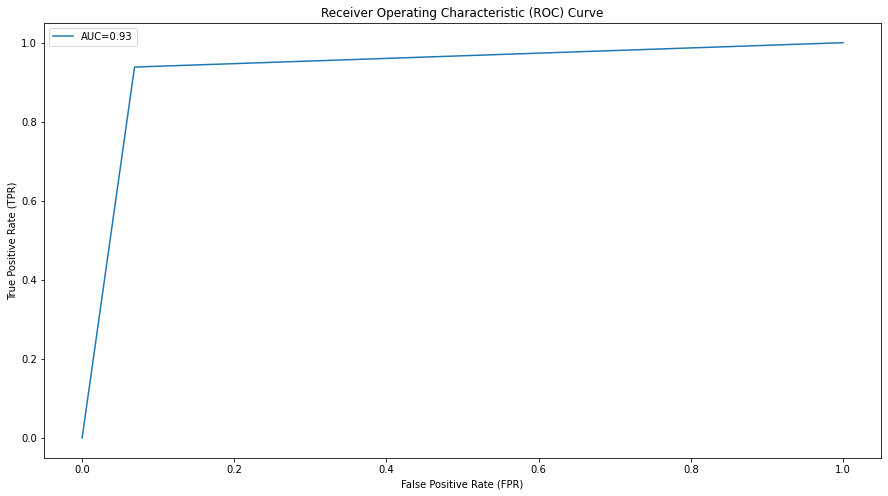

In [48]:
plt.figure(figsize=(15, 8))

plt.plot(fpr, tpr, label=f"AUC={roc_auc:.2f}")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()